In [1]:
import torch
from torch.nn import functional as F
from torch.optim import Adam
import numpy as np
import tqdm
from networks import Encoder, Decoder, Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def vae_loss(x, x_hat, mean, log_var):
    ''' reproduction error plus KL divergence
    '''
    reproduction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD               = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) # 1 + log_var = k + log det(Sigma(X))
    return reproduction_loss + KLD

In [2]:
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
X = mnist_trainset.data
X = X.float()
X /= 255.
X = X.to(device)

In [4]:
X.shape

torch.Size([60000, 28, 28])

In [5]:
hidden_dim = 400
latent_dim = 200
input_dim = 28 * 28

In [6]:
encoder = Encoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, output_dim=input_dim)
model = Model(encoder, decoder).to(device)
optimizer = Adam(model.parameters(), lr=5e-4)

In [7]:
n_epochs = 10
batch_size = 64
val = []
train = []

In [31]:
model.train()
call = tqdm.tqdm(range(n_epochs))
train_loss = float('inf')
for epoch in call:
    call.set_description("train loss: {:.2f}".format(train_loss))
    permutation = torch.randperm(X.size()[0])
    train_loss = 0.
    epo_length = len(list(range(0, X.size()[0], batch_size)))
    for i in range(0, X.size()[0] - batch_size, batch_size):
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_x = X[indices]
        batch_x = batch_x.reshape(64,-1)
        x_hat, mean, log_var = model(batch_x)
        loss = vae_loss(batch_x, x_hat, mean, log_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

train loss: 6085470.08: 100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


In [38]:
z = torch.randn(200).to(device).float()
x_hat = model.Decoder(z)

In [39]:
x_hat = x_hat.detach().cpu().numpy() * 255

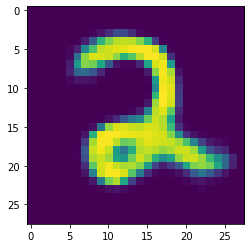

In [40]:
plt.imshow(x_hat.reshape(28,28))